# Manufacturing Optimization

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('price_demand_data.csv')

In [3]:
y = df['demand'].values.ravel()
X = df['price'].values.reshape(-1,1)

## 1. Find Residuals Using Linear Regression

In [4]:
clf = LinearRegression()
clf.fit(X,y)
itcpt, b1 = clf.intercept_, clf.coef_

In [5]:
itcpt, b1

(1924.7175435291083, array([-1367.71252416]))

In [6]:
residuals = np.array(df['demand']-clf.predict(X))

## 2. Generate New columns Predicted by Regression Model

In [7]:
c,g,t = 0.5, 0.75, 0.15

In [8]:
# Demand when p=1
demand_1 = (itcpt + (b1*1)).flatten() + residuals
df['demand_1'] = demand_1
df.head()

,price,demand,demand_1
0,1.05,283,351.385626
1,0.86,771,579.520247
2,1.21,185,472.219630
3,0.94,531,448.937249
4,0.76,1002,673.748994


## 3. Find Optimal Number of Newspapers to Produce

In [9]:
demand_1 = (itcpt + (b1*1)).flatten() + residuals

rhs1, rhs2 = demand_1*(X.flatten() - g), demand_1*(X.flatten() + t)
rhs = np.concatenate((rhs1, rhs2))

q = np.zeros((198,1))
q[:99], q[99:] = c-g, c+t

pre_h = np.zeros((99,99))
np.fill_diagonal(pre_h, 1)
h = np.tile(pre_h, (2,1))

A = np.concatenate((h,q), axis=1)

obj, obj[:-1] = np.zeros(100), 1.0 / 99
lb, lb[:-1] = np.zeros(len(obj)), -np.inf
sense = np.array(['<']*len(A))

In [10]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) 
spMod_con = spMod.addMConstrs(A, spMod_x, sense, rhs) 
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
spMod.Params.OutputFlag = 0 
spMod.optimize()

Academic license - for non-commercial use only - expires 2022-08-22
Using license file /Users/junsu/gurobi.lic


### Profit & Amount to Produce

In [11]:
spMod.objval

241.32971496927664

In [12]:
spMod_x.x[-1]

471.86537959089344

## 4. Assume more Realistic Situation
### Price affects Demands

In [13]:
obj, obj[2:] = np.zeros(101), 1.0/99

qdr, qdr[0,0] = np.zeros((len(obj),len(obj))), b1

A, sense, b = np.zeros((198,101)), np.array(['<']*len(A)), np.zeros(len(A))

A[:99, 0], A[99:, 0] = -(itcpt -b1*g + residuals), -(itcpt + b1*t + residuals)
A[:,1] = q.ravel()
A[:,2:] = h

rhs = np.zeros(len(A))
rhs[:99] = -(itcpt + residuals)*g
rhs[99:] = (itcpt + residuals)*t

lb, lb[2:] = np.zeros(len(obj)), -np.inf

In [14]:
portMod = gp.Model()
portMod_x = portMod.addMVar(len(obj),lb=lb)
portMod_con = portMod.addMConstrs(A, portMod_x, sense, rhs)
# Sigma is for the Quadratic part. #None is for linear part
portMod.setMObjective(qdr,obj,0,sense=gp.GRB.MAXIMIZE)
portMod.Params.OutputFlag = 0 
portMod.optimize()

### Profit & Amount to Produce

In [15]:
portMod.objval

234.42493487832894

In [16]:
portMod_x.x[:2]

array([  0.9536265 , 535.29100128])

## 5. Impose Randomness on the Demand 

In [24]:
xy = np.concatenate((X,y.reshape(-1,1)), axis=1)

def find_boots_demand(data,c,g,t):

    # Bootstrap Samples
    boots = data[np.random.choice(range(len(xy)), size=len(data), replace=True)]

    clf = LinearRegression()
    clf.fit(boots[:,0].reshape(-1,1),boots[:,1])
    itcpt, b1 = clf.intercept_, clf.coef_

    residuals = boots[:,1] - clf.predict(boots[:,0].reshape(-1,1))
    
    obj, obj[2:] = np.zeros(101), 1.0/99
    qdr, qdr[0,0] = np.zeros((len(obj),len(obj))), b1

    A = np.zeros((198,101))
    sense, b = np.array(['<']*len(A)), np.zeros(len(A))

    A[:99, 0], A[99:, 0] = -(itcpt -b1*g + residuals), -(itcpt + b1*t + residuals)
    
    q = np.zeros((198,1))
    q[:99], q[99:] = c-g, c+t
    A[:,1] = q.ravel()
    
    pre_h = np.zeros((99,99))
    np.fill_diagonal(pre_h, 1)
    h = np.tile(pre_h, (2,1))
    A[:,2:] = h

    rhs = np.zeros(len(A))
    rhs[:99],rhs[99:] = -(itcpt + residuals)*g, (itcpt + residuals)*t

    lb, lb[2:] = np.zeros(len(obj)), -np.inf

    portMod = gp.Model()
    portMod_x = portMod.addMVar(len(obj),lb=lb)
    portMod_con = portMod.addMConstr(A, portMod_x, sense, rhs)
    # Sigma is for the Quadratic part. #None is for linear part
    portMod.setMObjective(qdr,obj,0,sense=gp.GRB.MAXIMIZE)
    portMod.Params.OutputFlag = 0 
    portMod.optimize()

    return np.array((portMod_x.x[0], portMod_x.x[1], portMod.objval))

In [25]:
obj_vals = np.zeros((300,3))
for _ in range(len(obj_vals)):
    obj_vals[_] = find_boots_demand(xy,c,g,t)

In [28]:
#obj_vals

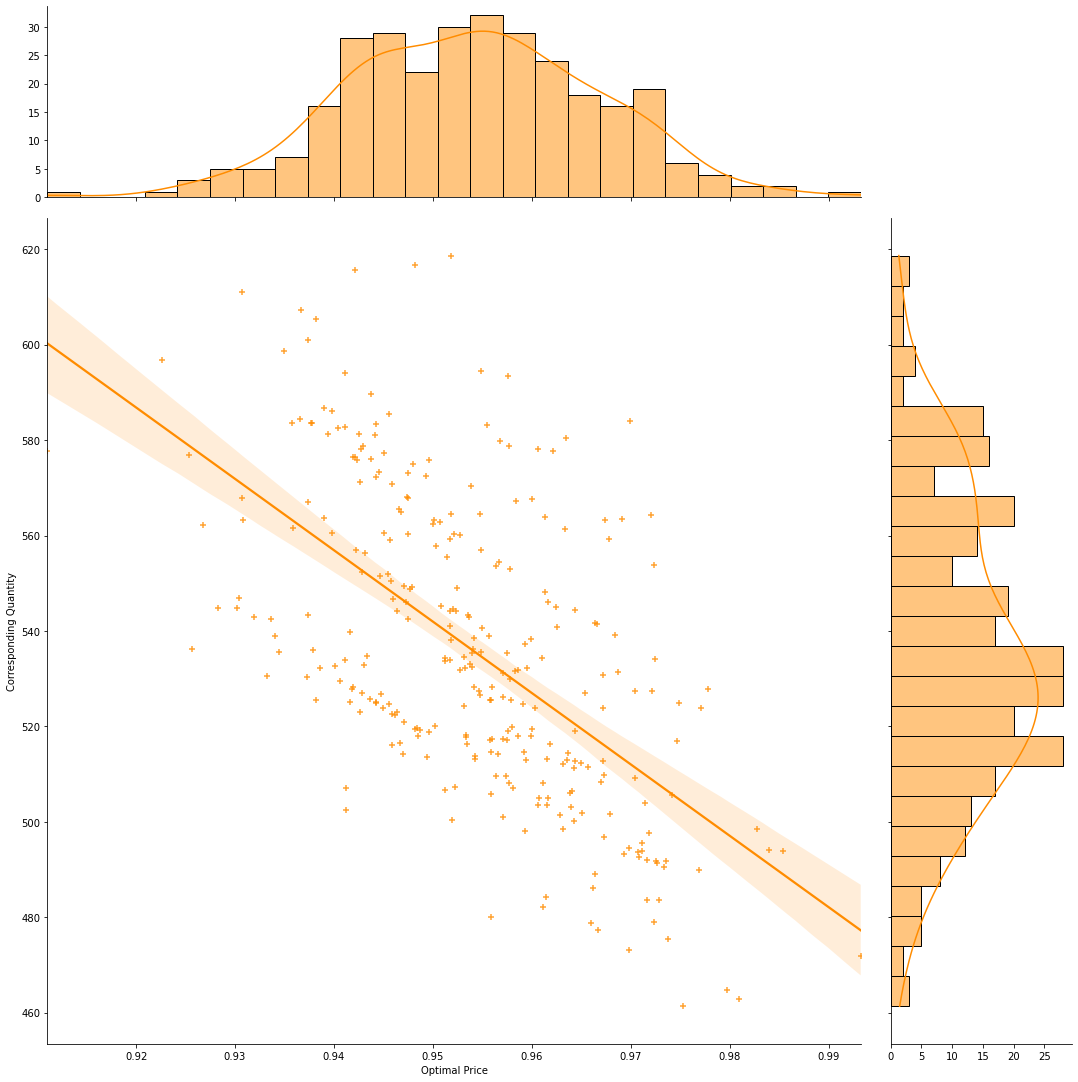

In [27]:
joint = sns.jointplot(x=obj_vals[:,0], y=obj_vals[:,1], kind='reg', marker="+",
             height=15, ratio=4, marginal_ticks=True, color='darkorange', space=None,
                     marginal_kws=dict(bins=25, fill=True))
#joint.fig.suptitle("Optimal Price and Corresponding Quantity")
joint.ax_joint.set_xlabel('Optimal Price')
joint.ax_joint.set_ylabel('Corresponding Quantity')
plt.show()